In [1]:
from importlib import reload
import json
import pretty_midi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# check gpu
print(tf..device_lib.list_local_devices())

In [17]:
import modules.midiMethods as midiMethods
reload(midiMethods)
from modules.midiMethods import *

import modules.dataMethods as dataMethods
reload(dataMethods)
from modules.dataMethods import *

import modules.models as models
reload(models)

import modules.mlClasses as mlClasses
reload(mlClasses)


<module 'modules.mlClasses' from '/home/ubuntu/storage/380-music-representation/modules/mlClasses.py'>

In [123]:
# if needed, read in filenames... specify if validation or test
maestro = pd.read_csv('training_data/maestro-v2.0.0withPeriod.csv', index_col=0)
filenames = list(maestro[maestro['split'] == 'train']['midi_filename'])

In [5]:
# store examples in json format
with open('training_data/note_bin_v1/nb_256_train0.95.json', 'w') as f:
    json.dump(train_95, f)

In [4]:
# or read them in
with open('training_data/note_bin_v2/nb_220_train1.json', 'r') as f:
    examples = json.load(f)
# with open('training_data/note_bin_v2/nb_220_val.json', 'r') as f:
#     val = json.load(f)
with open('training_data/note_bin_v2/nb_220_train1_chromaweighted.json', 'r') as f:
    chroma = json.load(f)

In [6]:
with open('training_data/note_bin_v2/nb_220_train1_chromalowest.json', 'r') as f:
    chroma = json.load(f)

In [7]:
print(len(examples))
print(len(chroma))

48037
48037


In [103]:
with open('training_data/note_bin_v1/nb_256_train_chroma1.00.json', 'w') as f:
    json.dump(ex_c.tolist(), f)

In [ ]:
# for nb version 1:
# vocab={"pitch":88, "shift_M":10, "shift_m":60, "duration_M":18, "duration_m":30, "velocity":32}
# for nb version 2:
vocab={"pitch":88, "shift_M":10, "shift_m":24, "duration_M":13, "duration_m":16, "velocity":16}

In [ ]:
# build simple model
# excellent example of recurrent model here https://www.tensorflow.org/tutorials/text/text_generation
hidden_state = 512
lstm_layers = 3
seq_length = len(examples[0]) - 1
model2 = models.create_model1(hidden_state_size=hidden_state, lstm_layers=lstm_layers,
                              seq_length=seq_length)
training_generator = mlClasses.DataGenerator(examples, augment=True)
val_gen = mlClasses.DataGenerator(val, augment=False)

In [19]:
model2.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("weights/model1/{epoch:02d}-{train_loss:.2f}.hdf5", monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=True)
epochs=50
history2 = model2.fit_generator(training_generator, validation_data=val_gen, epochs=epochs)
model2.save_weights(f'models/nbmodel3/model{epochs}e{hidden_state}ss{lstm_layers}l.h5')
with open(f'models/nbmodel3/history{epochs}ePd.json', 'w') as f:
    json.dump(pd.DataFrame(history.history).to_json(), f)


Epoch 1/20
322/322 [==============================] - 237s 736ms/step - loss: 13.1786 - dense_6_loss: 3.8935 - dense_7_loss: 0.0925 - dense_8_loss: 2.8613 - dense_9_loss: 0.6869 - dense_10_loss: 2.9975 - dense_11_loss: 2.6470 - dense_6_accuracy: 0.0449 - dense_7_accuracy: 0.9827 - dense_8_accuracy: 0.2096 - dense_9_accuracy: 0.7747 - dense_10_accuracy: 0.1366 - dense_11_accuracy: 0.1310 - val_loss: 12.2064 - val_dense_6_loss: 3.6095 - val_dense_7_loss: 0.0771 - val_dense_8_loss: 2.7222 - val_dense_9_loss: 0.5180 - val_dense_10_loss: 2.7510 - val_dense_11_loss: 2.5287 - val_dense_6_accuracy: 0.0763 - val_dense_7_accuracy: 0.9830 - val_dense_8_accuracy: 0.2281 - val_dense_9_accuracy: 0.8299 - val_dense_10_accuracy: 0.1698 - val_dense_11_accuracy: 0.1484
Epoch 2/20
322/322 [==============================] - 236s 733ms/step - loss: 11.6700 - dense_6_loss: 3.4521 - dense_7_loss: 0.0583 - dense_8_loss: 2.5982 - dense_9_loss: 0.4496 - dense_10_loss: 2.6230 - dense_11_loss: 2.4890 - dense_6_ac

In [10]:
# This works just like this:
import modules.models as models
reload(models)

<module 'modules.models' from '/home/ubuntu/music-ml/380-music-representation/modules/models.py'>

In [ ]:
# tf.train.latest_checkpoint('weights\first_attempt')
hidden_state = 512
lstm_layers = 3
prediction_model = models.create_model1(batch_size=1, stateful=True, hidden_state_size=hidden_state, lstm_layers=lstm_layers)

In [23]:
# prediction_model.load_weights('weights/note_bin/model2_60epochs512state3layer.h5')
prediction_model.load_weights('models/nbmodel14/12-10.46.hdf5')
for i in range(1):
    temperatures = [0.025 + i * 0.003] * 6
    # temperatures = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
    # input_notes = [[44,0,0,4,3,20], [48,0,0,4,3,20], [51,0,0,3,3,20],[56,0,5,3,3,20]]
    input_notes = pm2note_bin(pretty_midi.PrettyMIDI('midi/starts/fug2.mid'))
    new_seq_length = 400
    new_seq = models.generate_music(prediction_model, new_seq_length, temperatures, input_notes)
    ns = [[int(a) for a in note] for note in new_seq]
    pm = note_bin2pm(ns)
    pm.write(f'midi/nb/12e12fug2-{new_seq_length}{temperatures[0]}.mid')

In [9]:
note_bin2pm(input_notes).write('midi/hellad.mid')

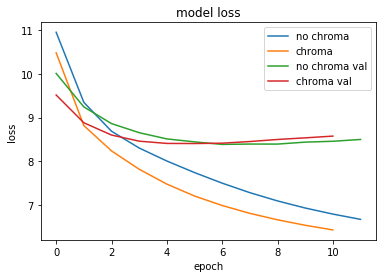

In [9]:
import ast
with open(f'models/nbcmodel3/history40e.json', 'r') as f:
    hist = ast.literal_eval(json.load(f))
with open(f'models/nbcmodel4/history40e.json', 'r') as f:
    hist2 = ast.literal_eval(json.load(f))
metric = 'loss'
# print(hist)
plt.plot(hist[metric])
plt.plot(hist2[metric])
plt.plot(hist['val_' + metric])
plt.plot(hist2['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['no chroma', 'chroma', 'no chroma val', 'chroma val'], loc='upper right')
plt.savefig('?')
plt.show()

In [ ]:
with open(f'models/nbcmodel4/history120eStr.json', 'r') as f:
    hist = ast.literal_eval(json.load(f))
metric = 'loss'
# print(hist)
plt.plot(hist[metric])
plt.plot(hist['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

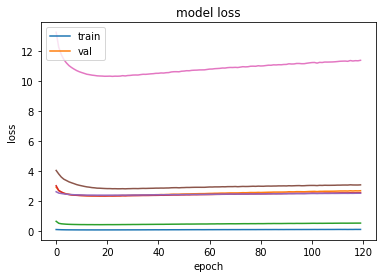

In [8]:
pm = 
metric = 'loss'
# print(hist)
plt.plot(hist['val_dense_1_' + metric])
plt.plot(hist['val_dense_2_' + metric])
plt.plot(hist['val_dense_3_' + metric])
plt.plot(hist['val_dense_4_' + metric])
plt.plot(hist['val_dense_5_' + metric])
plt.plot(hist['val_dense_' + metric])
plt.plot(hist['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
pm = pretty_midi.PrettyMIDI(f'midi/BergNoPedal.mid')
M_shift_ms = 600
m_shift_ms = 30
M_duration_ms = 600
m_duration_ms = 60
nb = pm2note_bin(pm, M_shift_ms = M_shift_ms, m_shift_ms = m_shift_ms,  M_duration_ms = M_duration_ms, m_duration_ms = m_duration_ms)
pm2 = note_bin2pm(nb, M_shift_ms = M_shift_ms, m_shift_ms = m_shift_ms,  M_duration_ms = M_duration_ms, m_duration_ms = m_duration_ms)
pm2.write('midi/BergQ25.mid')

In [27]:
pm = pretty_midi.PrettyMIDI(f'midi/LisztNoPedal.mid')
durations = sorted([(n.end - n.start) * 1000 for n in pm.instruments[0].notes])
print(durations[:10])

[4.000000000001336, 7.999999999995566, 7.999999999995566, 8.000000000002672, 8.000000000002672, 12.00000000000001, 12.000000000000455, 12.000000000000455, 15.999999999998238, 19.99999999999602]


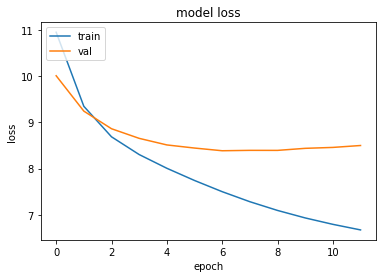

In [18]:
models.plt_metric(hist)
plt.savefig('??')
plt.show()

